<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Indoor Sensors</b></header>

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Introduction</b></p>


<p style = 'font-size:16px;font-family:Arial'>In this demo, we will explore using Python to leverage <b>4D Analytics</b> in Teradata Vantage using the  <b>teradataml</b> package. <br> We will use a combination of data that is stored in the Vantage SQL engine and data coming directly from a cloud object store.</p>

<p style = 'font-size:16px;font-family:Arial'>We will connect to Vantage and explore a sensor dataset provided by the <b>Intel Berkeley Research Lab</b>.</p>

<b style = 'font-size:20px;font-family:Arial;color:#E37C4D'>Experience</b>

<p style = 'font-size:16px;font-family:Arial'>The Experience section takes about 15 minutes to run.</p>

<p style = 'font-size:16px;font-family:Arial'>First step is to import the necessary packages:</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getpass
#import tdconnect

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.dataframe.dataframe import DataFrame
from teradataml.context.context import *
from teradataml.options.display import display
from teradataml.dataframe.dataframe import in_schema

<p style = 'font-size:16px;font-family:Arial'>Next, connect to Vantage:</p>

In [ ]:
eng = create_context(host = 'host.docker.internal', username='demo_user', password = getpass.getpass())

<p style = 'font-size:16px;font-family:Arial'> Let's validate that we are connected:</p>

In [ ]:
print(eng)

In [ ]:
# Get the current logged in user for the session
cur_user = eng.execute('SELECT CURRENT_USER').fetchall()[0][0]

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Accessing the Data</b></p>
<p style = 'font-size:16px;font-family:Arial'>These demos will work either with foreign tables accessed from Cloud Storage via NOS or you may import the tables to your machine. If you import data for multiple demos, you may need to use the Data Dictionary "Manage Your Space" routine to cleanup tables you no longer need.</p> 
    
<p style = 'font-size:16px;font-family:Arial'>Use the link below to access the 2 options for using data from the data dictionary notebook:

[Click Here to get data for this notebook](../Data_Dictionary/Data_Dictionary.ipynb#TRNG_IndoorSensor)

[Click Here to Manage Your Space](../Data_Dictionary/Data_Dictionary.ipynb#Manage_Your_Space)

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Walkthrough</b></p>


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 1: Check sensor locations</b>
<p style = 'font-size:16px;font-family:Arial'>We have the lab sensor locations already loaded into Vantage, so load them into a DataFrame:

In [ ]:
mote_x_y = DataFrame(in_schema('TRNG_IndoorSensor', 'sensor_locations'))

In [ ]:
mote_x_y.head(5)

In [ ]:
mote_x_y.shape

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 2: Plot Sensor Locations in 2D Floor Plan</b></p>

<p style = 'font-size:16px;font-family:Arial'>Let's make sure our data matches the Intel provided map of the sensor locations:</p>


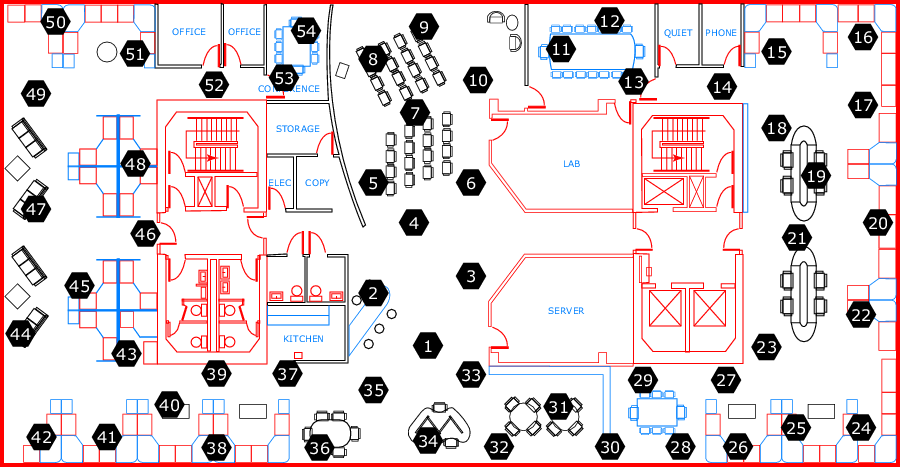

<p style = 'font-size:16px;font-family:Arial'>Note default plot origin(0,0) is bottom left, while in the Intel lab diagram, origin is top right. Therefore we need to flip the origin when plotting.</p>

In [ ]:
mote_x_y_pandas = mote_x_y.to_pandas().reset_index()   # Get a pandas DataFrame for plotting

mote_x_y_pandas.drop('index', axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(16, 9))

for x, y, z in zip(mote_x_y_pandas.x, mote_x_y_pandas.y, mote_x_y_pandas.id):
    ax.annotate(z, (x, y))

ax.scatter(mote_x_y_pandas.x, mote_x_y_pandas.y)
    
left, right = ax.get_xlim()
ax.set_xlim(right, left)        # invert the X axis

left, right = ax.get_ylim()
ax.set_ylim(right, left)        # invert the Y axis

plt.show()

<p style = 'font-size:16px;font-family:Arial'>Looks good! Now let's explore the connectivity between the sensors...</p>

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 3: Check Sensor Communications</b></p>

 <p style = 'font-size:16px;font-family:Arial'>We have the connectivity between the sensors also loaded into Vantage:

In [ ]:
connectivity = DataFrame(in_schema('TRNG_IndoorSensor', 'connectivity'))

In [ ]:
connectivity.head(5)

In [ ]:
connectivity_pandas = connectivity.to_pandas().reset_index()

connectivity_pandas.drop('index', axis=1, inplace=True)

len(connectivity_pandas.index)

<p style = 'font-size:16px;font-family:Arial'>Clean up and remove some of the null data</p>

In [ ]:
connectivity_clean = connectivity_pandas.query('sendid != 0')
len(connectivity_clean.index)

In [ ]:
connectivity_clean = connectivity_clean.query('receiveid != 0')
len(connectivity_clean.index)

In [ ]:
connectivity_clean = connectivity_clean.query('reachprob != 0')
len(connectivity_clean.index)

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 4: Visualize Sensor Communications</b></p>
<p style = 'font-size:16px;font-family:Arial'>Build connectivity network:</p>

In [ ]:
import networkx as nx

In [ ]:
DG = nx.DiGraph()
DG.add_weighted_edges_from(zip(connectivity_clean.sendid, connectivity_clean.receiveid, connectivity_clean.reachprob))

In [ ]:
# Define node positions data structure (dict) for plotting, nodes positions shown as sensor locations.
pos = mote_x_y_pandas.set_index('id').T.to_dict('list')

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(pos.items())[0:5])

<p style = 'font-size:16px;font-family:Arial'><b>Use reachprob as weight, which is the probability of sensorA's msg sent to sensorB.</b></p>

<ol style = 'font-size:16px;font-family:Arial'> 
    <li>reachprob>0.5 shown in red</li>
    <li>0.5>=reachprob>0.1 shown in blue</li>
    <li>0.1>=reachprob shown in green</li> 
</ol>
<p style = 'font-size:16px;font-family:Arial'><b>Node size reflecting the sensor's capability of send/receive msg from other sensors. 
    Bigger node size imply better communications.</b></p>

In [ ]:
plt.figure(figsize=(16, 9))

elarge = [(u, v) for (u, v, d) in DG.edges(data=True) if d['weight'] > 0.5]
esmall1 = [(u, v) for (u, v, d) in DG.edges(data=True) if ((d['weight'] > 0.1) and (d['weight'] <= 0.5))]
esmall2 = [(u, v) for (u, v, d) in DG.edges(data=True) if d['weight'] <= 0.1]

# nodes
d = dict(DG.degree(weight='weight'))
nx.draw_networkx_nodes(DG, pos, nodelist=d.keys(), node_size=[ v*100 for v in d.values()], 
                       node_color='white', edgecolors='black')

# edges
nx.draw_networkx_edges(DG, pos, edgelist=elarge, arrowstyle="->", arrowsize=1,
                       width=0.5, edge_color='r')
nx.draw_networkx_edges(DG, pos, edgelist=esmall1, arrowstyle="->", arrowsize=1,
                       width=0.2, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_edges(DG, pos, edgelist=esmall2, arrowstyle="->", arrowsize=1,
                       width=0.05, alpha=0.5, edge_color='g', style='dashed')

# labels
nx.draw_networkx_labels(DG, pos, font_size=15, font_family='sans-serif')

plt.axis('off')
plt.show()

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 5: Get Sensor Readings Data from the Object Store</b></p>

<p style = 'font-size:16px;font-family:Arial'>Sensors and other IOT devices generate <b>a lot</b> of data. In our case th sensor data is located in an object store because of the cost/performance tradeoff and resilience it provides.</p>

<p style = 'font-size:14px;font-family:Arial'><b>Create a CSV Schema</b></p>

<p style = 'font-size:16px;font-family:Arial'>We know what the format of the data is already, so start by creating a schema so we can reference the CSV columns by name when reading it:</p>

In [ ]:
try:
    eng.execute(f'''CREATE CSV SCHEMA sensor_schema_${cur_user} AS
'{{"field_delimiter":",","field_names":["date", "time", "epoch", "moteid", "temperature", "humidity", "light", "voltage"]}}';''')
except Exception as e:
    if str(e.args).find('4321') >= 1:
        pass
    else:
        raise

<p style = 'font-size:14px;font-family:Arial'><b>Create the Foreign Table</b></p>

<p style = 'font-size:16px;font-family:Arial'>Now create a Foreign Table to allow easy access to the raw sensor data:</p>

In [ ]:
try:
    eng.execute(f'''DROP TABLE sensors_csv''')
except Exception as e:
    if str(e.args).find('3807') >= 1:
        pass
    else:
        raise

eng.execute(f'''CREATE FOREIGN TABLE sensors_csv
( Location VARCHAR(2048) CHARACTER SET UNICODE CASESPECIFIC, 
  Payload DATASET INLINE LENGTH 64000 STORAGE FORMAT CSV WITH SCHEMA sensor_schema_${cur_user}
)
USING (LOCATION('/s3/s3.amazonaws.com/trial-datasets/IndoorSensor/data.csv'));''')

<p style = 'font-size:16px;font-family:Arial'>Here is what the raw data looks like - note each row is coming back into a single 'Payload' column, we will address this in the next step...</p>

In [ ]:
sensors_csv = DataFrame('sensors_csv');

<p style = 'font-size:16px;font-family:Arial'>Take a sample of a few rows (10):</p>

In [ ]:
sensors_csv.sample(10)

<p style = 'font-size:14px;font-family:Arial'><b>Create a View for Easy Access</b></p>

<p style = 'font-size:16px;font-family:Arial'>Create a view on top of the raw data that puts structure and proper datatypes on the sensor data:</p>

In [ ]:
eng.execute('''REPLACE VIEW sensor_readings
  AS 
    (SELECT
      CAST(payload.."date" AS DATE FORMAT 'YYYY-MM-DD') sensdate,
      CAST(payload.."time" AS TIME(6) FORMAT 'HH:MI:SSDS(F)') senstime,
      CAST(payload..epoch AS BIGINT) epoch,
      CAST(payload..moteid AS INTEGER) moteid,
      CAST(payload..temperature AS FLOAT) ( FORMAT '-ZZZ9.99') temperature,
      CAST(payload..humidity AS FLOAT) ( FORMAT '-ZZZ9.99') humidity,
      CAST(payload..light AS FLOAT) ( FORMAT '-ZZZ9.99') light,
      CAST(payload..voltage AS FLOAT) ( FORMAT '-ZZZ9.99') voltage,
      CAST(payload.."date" || ' ' || payload.."time" AS TIMESTAMP FORMAT 'YYYY-MM-DDBHH:MI:SSDS(F)') sensdatetime
  FROM sensors_csv);''')

<p style = 'font-size:16px;font-family:Arial'>Now take a look at the formatted data:</p>

In [ ]:
sensor_readings = DataFrame('sensor_readings');

In [ ]:
sensor_readings.sample(10)

<p style = 'font-size:14px;font-family:Arial'><b>Final View - Clean Up Data and Join</b></p>

<p style = 'font-size:16px;font-family:Arial'>Clean up the data a little - limit the sensorid (moteid) to 54 because there are supposed to only be 54 sensors.</p>

<p style = 'font-size:16px;font-family:Arial'>We also want to join with our local data table that gives us the location of each sensor:</p>

In [ ]:
eng.execute('''REPLACE VIEW sensor_clean AS ( 
    SELECT * FROM sensor_readings sr 
    LEFT JOIN TRNG_IndoorSensor.sensor_locations sl
    ON sr.moteid = sl.id
    WHERE sr.moteid <= 54
);''')

In [ ]:
sensor_readings = DataFrame('sensor_clean')

<p style = 'font-size:16px;font-family:Arial'>Get some statistics on the sensor readings (we are using a random 10% sample of the full dataset):</p>

In [ ]:
sensor_readings.sample(frac = 0.1).describe()

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 6: Time Series Analysis</b></p>

<p style = 'font-size:16px;font-family:Arial'>Our dataset is from a wireless sensor network composed of 54 sensors monitoring temperature, humidity, lighting conditions of the surrounding environment as well as voltage of each sensor. Each sensor monitors and submits a package containing the above information once every 31 s. Often times we will want to look at data in different time frames, this may be far more granular than we need for instance.</p>

<p style = 'font-size:16px;font-family:Arial'>This is where the powerful Time Series functionality of Vantage comes in. Using the GROUP BY TIME we can easily group this into 1hr increments... But this could be by minute, day, whatever time interval you choose!</p>

In [ ]:
data1hr = sensor_readings.resample(rule="HOURS(1)", value_expression="moteid", on="sensdatetime")   

In [ ]:
data2min = sensor_readings.resample(rule="2minute", value_expression="moteid", on="sensdatetime")

In [ ]:
qry = '''
SELECT 
$TD_TIMECODE_RANGE AS T_RANGE 
, $TD_GROUP_BY_TIME AS T_GROUP 
, moteid
, AVG(temperature) AS avg_temperature 
, AVG(humidity) AS avg_humidity
, AVG(light) AS avg_light
, AVG(voltage) AS avg_voltage
, AVG(x) AS x
, AVG(y) AS y
FROM 
sensor_clean
GROUP BY TIME (HOURS(1) AND moteid)                                          
USING TIMECODE(sensdatetime)
ORDER BY 1, 3;
'''
data2hr = pd.read_sql(qry, eng)

In [ ]:
data2hr.sample(10)

<p style = 'font-size:16px;font-family:Arial'>Vantage has generated the RANGE and GROUP columns for us to identify the timeslot the data is for. You can iterate and change the way the time series sensor data is aggregated. Try changing HOURS to DAYS and see the results. </p>

<p style = 'font-size:16px;font-family:Arial'>Now lets group the data again by Sensor id to see a summary of all 54 sensors:</p>

In [ ]:
data2hr_grp = data2hr.groupby('moteid')

In [ ]:
# review first group
data2hr_grp.first()

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 7: Visualise the Hourly Sensor Readings</b></p>

<p style = 'font-size:16px;font-family:Arial'>Now that we have used Vantage to bring in sensor data from an object store, clean it up, join it with additional data and change the time interval to hourly - lets take a look at it!</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Temperature is in degrees Celsius.</li>
    <li>Humidity is temperature corrected relative humidity, ranging from 0-100%.</li>
    <li>Light is in Lux (a value of 1 Lux corresponds to moonlight, 400 Lux to a bright office, and 100,000 Lux to full sunlight.)</li>
    <li>Voltage is expressed in volts.</li>

</ol>

In [ ]:
# sens_type can be avg_temperature, avg_humidity, avg_light,  or avg_voltage.
sens_type = "avg_temperature"

In [ ]:
# Note that not all 54sensors have readings in every time range, 
# therefor need to get the list of keys from the group.
fig, ax = plt.subplots(figsize=(16, 10))

plt.ylabel(sens_type)

for i in data2hr_grp.groups.keys():
    plt.plot(data2hr_grp.get_group(i).T_GROUP, 
             data2hr_grp.get_group(i)[sens_type])
    
plt.xticks(rotation='vertical')
#plt.legend(list(data2hr_grp.groups.keys()))
plt.show;

<p style = 'font-size:16px;font-family:Arial'><b>Try changing the sensor reading from temperature to another sensor (humidity, light, voltage) and see the results. You can also change the time frame aggregation from an hour to something different and see the changes.</b></p>

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Clean Up</b></p>

In [ ]:
eng.execute('''DROP VIEW sensor_readings;''')

In [ ]:
eng.execute('''DROP FOREIGN TABLE sensors_csv;''')

In [ ]:
eng.execute(f'''DROP CSV SCHEMA sensor_schema_${cur_user};''')

<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Dataset</b></p>


<p style = 'font-size:16px;font-family:Arial;'>The <b>sensor_readings</b> dataset contains 2.3 Million records - the output of 54 sensors between February 28th and April 5th, 2004:</p>

<p style = 'font-size:16px;font-family:Arial'>
- `date`: date of the sensor reading
- `time`: time of the sensor reading
- `epoch`: store identifier where the order was taken
- `moteid`: unique sensor identifier
- `temperature`: temperature
- `humidity`: humidity
- `light`: light
- `voltage`: light
    </p>
    
<p style = 'font-size:16px;font-family:Arial'>
<b>sensor_locations</b> contains xy coordinates of sensors in meters relative to the upper right corner of the lab

- `id`: sensor identifier
- `x`: X coordinate (M)
- `y`: Y coordinate (M)
</p>
    
<p style = 'font-size:16px;font-family:Arial'>
<b>connectivity</b> the sensors are wirelessly interconnected and due to locations / environment the connections vary in strength 

- `sendid`: sensor id of sendor
- `receiveid`: sensor id of receiver
- `reachprob`: probability of a message from a sender successfully reaching a receiver
</p>

<p style = 'font-size:16px;font-family:Arial'>This data, the Intel Berkeley Research Lab data set, was collected through the hard work of: Peter Bodik, Wei Hong, Carlos Guestrin, Sam Madden, Mark Paskin, and Romain Thibaux. Mark aggregated the raw connectivity information over time and generated the beautiful network layout diagram. Sam and Wei wrote TinyDB and other software for logging data. Intel Berkeley provided hardware. The TinyOS team, in particular Joe Polastre and Rob Szewczyk, provided the software infrastructure and hardware designs that made this deployment possible.

http://db.csail.mit.edu/labdata/labdata.html
    </p>

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">Copyright © Teradata Corporation - 2023. All Rights Reserved.</footer>